# Seam Phase 1 openVP data creation with Devito - OBC configuration

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import os
import segyio
import numpy as np
import random
import matplotlib.pyplot as plt
import pylops
import devito

from scipy.interpolate import RegularGridInterpolator
from examples.seismic import Model, RickerSource

from waveeqmod import Acoustic2DDevito
from utils import fixed_to_fixed_streamer, fixed_to_continous_streamer

devito.configuration['log-level'] = 'ERROR'

## Velocity model

In [2]:
# Dimensions
nz, nx = 1501, 1751
dz, dx = 10, 20

# Velocity
vp = segyio.open('/mnt/datawaha_dig/Data/Seam_Phase1/SEAM_I_2D_Model/SEAM_Vp_Elastic_N23900.sgy',
                 ignore_geometry=True)
vp2d = segyio.collect(vp.trace[:]).T

#vp2d = vp2d[:-20]
#nz -= 20 # remove bottom layer

In [3]:
# Resample on finer grid
dxint, dzint = 12.5, 12.5 # good for 10hz
x = np.arange(nx) * dx
z = np.arange(nz) * dz
xint = np.arange(x[0], x[-1], dxint)
zint = np.arange(z[0], z[-1], dzint)
nxint, nzint = len(xint), len(zint)
X, Z = np.meshgrid(xint, zint, indexing='ij')
XZ = np.vstack((X.ravel(), Z.ravel())).T

vp2dinterp = np.zeros(nxint*nzint, dtype=np.float32)
interpolator = RegularGridInterpolator((x,z), vp2d.T, bounds_error=False, fill_value=0)
vp2dinterp = interpolator(XZ).reshape(nxint, nzint).T

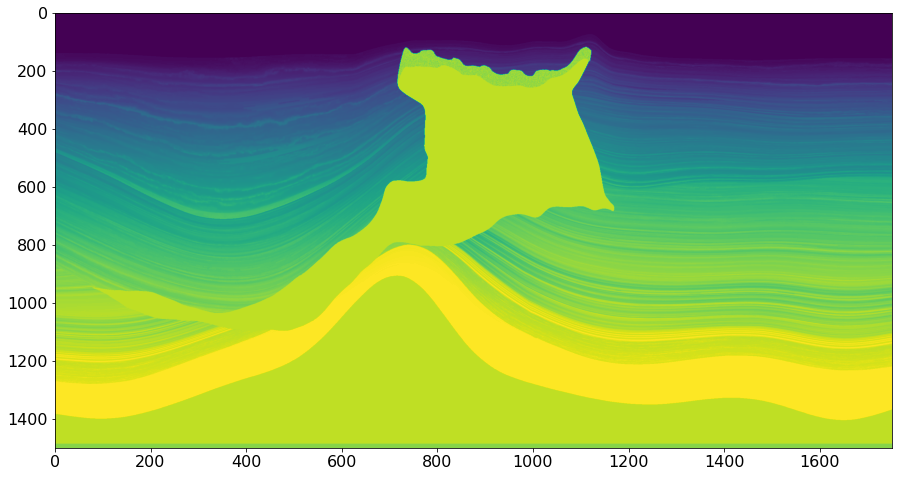

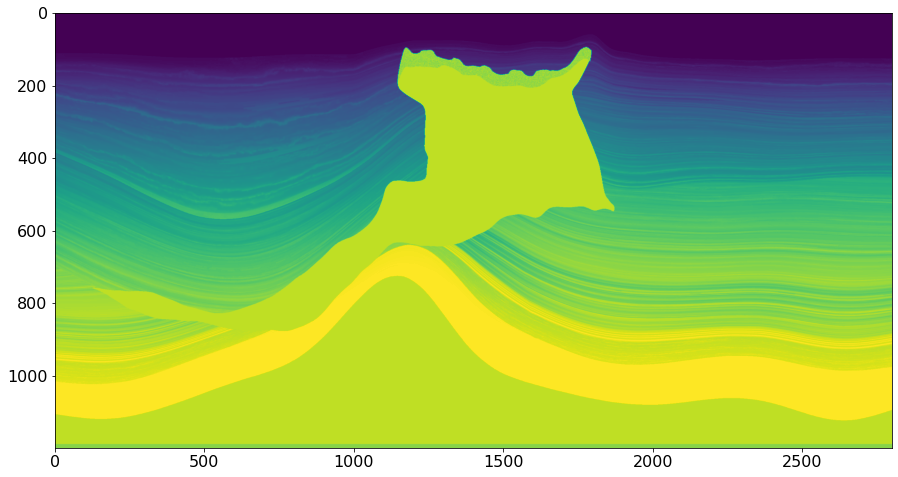

In [4]:
plt.figure(figsize=(15, 8))
plt.imshow(vp2d)
plt.axis('tight')

plt.figure(figsize=(15, 8))
plt.imshow(vp2dinterp)
plt.axis('tight');

## Acquisition geometry

In [5]:
#model parameter
shape = (nxint, nzint)
spacing = (dxint, dzint)
origin = (0, 0)

#geometry arrange
nrec = nxint
nsrc = 3
iosrc = 800 # for 12.5
osrc = spacing[0] * iosrc
idsrc = 100

# other modelling params
nbl = 150 # Number of boundary layers around the domain
space_order = 6 # Space order of the simulation
f0 = 10 # Source peak frequency (1/ms)
fs = True
fslabel = '_fs' if fs else ''

t0 = 0.
tn = 30000 # Total simulation time
tn_blen = 1000000 # Total simulation time of blended data
dt_obs = 4 # Time sampling of observed data

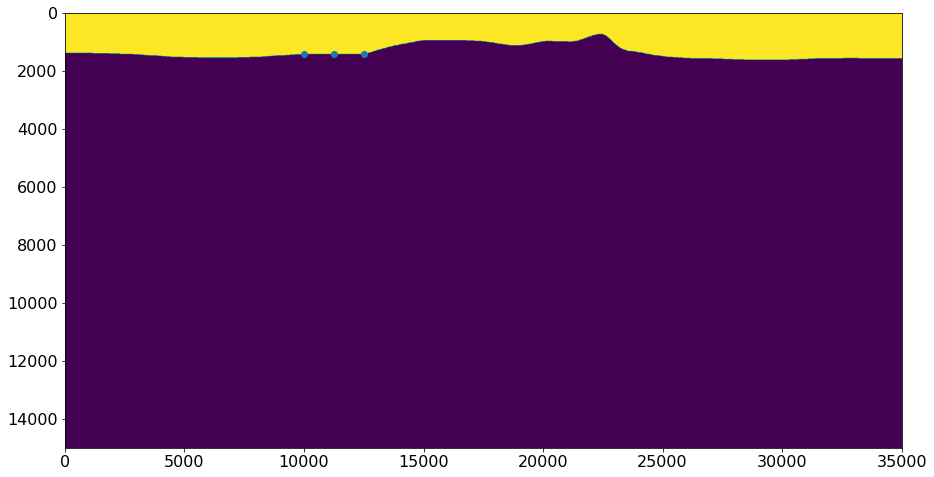

In [6]:
# sources and receivers
rec_x, rec_z = np.arange(0, nrec) * spacing[0], 20

watermask = vp2dinterp == 1490.0
src_x = np.arange(0, nsrc) * idsrc * spacing[0] + osrc
src_z = np.sum(watermask, axis=0)[iosrc:iosrc+nsrc*idsrc:idsrc] * spacing[1]

plt.figure(figsize=(15, 8))
plt.imshow(watermask, extent=(origin[0], origin[0] + nxint * spacing[0],
                              origin[1] + nzint * spacing[1], origin[1]))
plt.scatter(src_x, src_z)
plt.axis('tight');

In [7]:
awe = Acoustic2DDevito()

awe.create_model(shape, origin, spacing, vp2dinterp.T, space_order, nbl=nbl, fs=fs)
awe.create_geometry(src_x=src_x, src_z=src_z,
                    rec_x=rec_x, rec_z=rec_z,
                    t0=t0, tn=tn, src_type='Ricker', f0=f0)

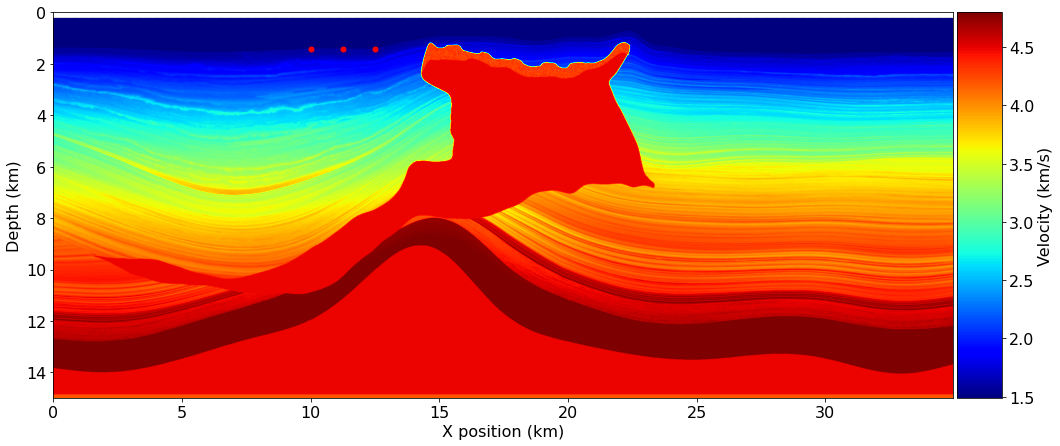

In [8]:
awe.plot_velocity(figsize=(17, 9))

## Solve one shot

In [9]:
isrc = nsrc//2
d, _, _ = awe.solve_one_shot(isrc)

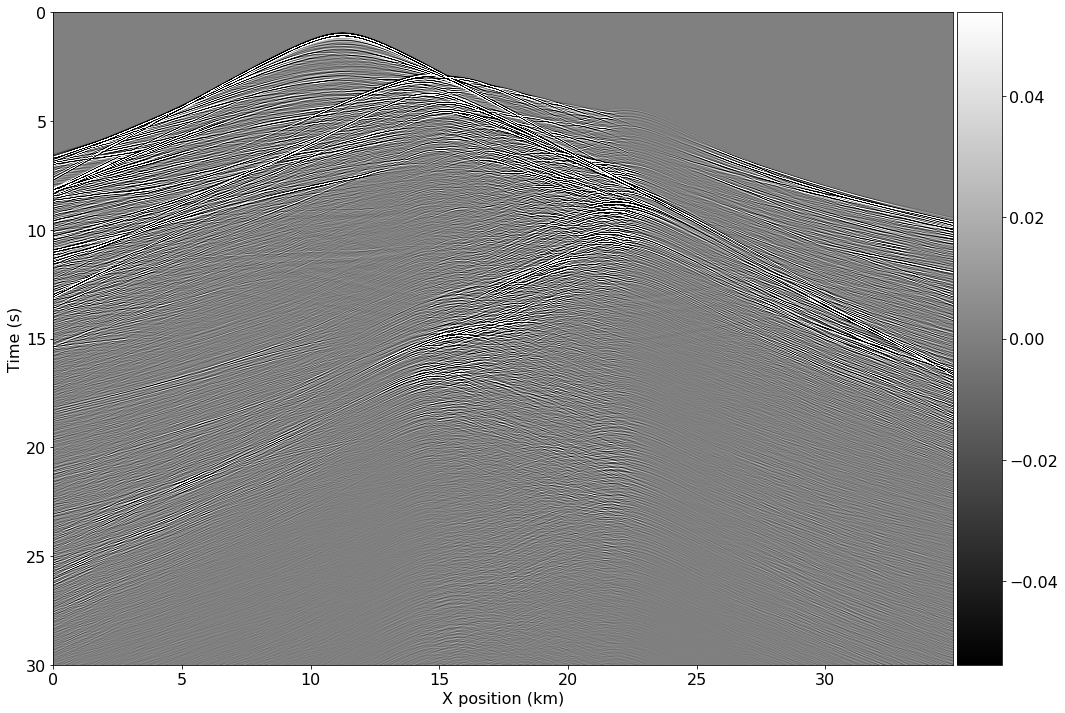

In [10]:
ax = awe.plot_shotrecord(d.data, clip=1e-2)

## Solve all shots

In [11]:
dtot, taxistot = awe.solve_all_shots(dt=dt_obs, figdir=f'figs_f0{f0}{fslabel}',
                                     datadir=f'shots_f0{f0}{fslabel}', savedtot=False)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [03:28<00:00, 69.63s/it]
